In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
eeg_data = np.load('data/eeg_data_20250417_143842.npy')
eeg_ts = np.load('data/timestamps_20250417_143842.npy')

In [9]:
print(np.shape(eeg_data))
print(np.shape(eeg_ts))

(7523, 8)
(7523,)


In [46]:
eeg_ts = eeg_ts - eeg_ts[0]
print(eeg_ts)

[0.00000000e+00 3.99999999e-03 7.99999997e-03 ... 3.00071953e+01
 3.00111953e+01 3.00151953e+01]


In [10]:
markers_df = pd.read_csv('data/markers_20250417_143757.csv')
print(markers_df)

                     timestamp   event_type  eeg_start_time  stimulus  \
0   2025-04-17T14:38:12.214421    eeg_start    1.744915e+09       NaN   
1     2025-04-17T18:38:13.216Z   game_start             NaN       NaN   
2     2025-04-17T18:38:13.216Z  round_start             NaN       NaN   
3     2025-04-17T18:38:13.217Z     stimulus             NaN    circle   
4     2025-04-17T18:38:14.169Z     response             NaN    circle   
5     2025-04-17T18:38:16.170Z     stimulus             NaN    square   
6     2025-04-17T18:38:16.814Z     response             NaN    square   
7     2025-04-17T18:38:18.816Z     stimulus             NaN    circle   
8     2025-04-17T18:38:19.373Z     response             NaN    circle   
9     2025-04-17T18:38:21.374Z     stimulus             NaN    circle   
10    2025-04-17T18:38:22.127Z     response             NaN    circle   
11    2025-04-17T18:38:24.128Z     stimulus             NaN  triangle   
12    2025-04-17T18:38:25.305Z     response        

In [52]:
from scipy import signal

sfreq = 1 / np.mean(np.diff(eeg_ts))

lowcut = 4  # Hz
highcut = 40  # Hz
order = 4

nyquist = sfreq / 2
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(order, [low, high], btype='band')

eeg_ch1 = signal.filtfilt(b, a, eeg_data[:, 0])
eeg_ch2 = signal.filtfilt(b, a, eeg_data[:, 1])

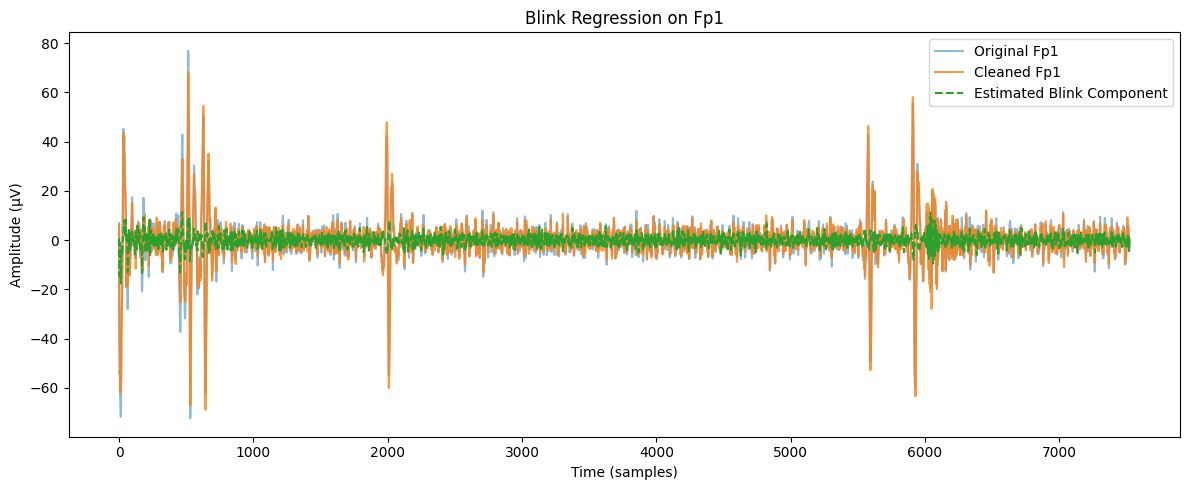

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Assume eeg_ch1 = Fp1, eeg_ch2 = Fp2
fp1 = eeg_ch1
fp2 = eeg_ch2

# Step 1: Create synthetic blink signal
blink_signal = fp1 - fp2

# Step 2: Estimate beta (regression coefficient)
beta = np.dot(blink_signal, fp1) / np.dot(blink_signal, blink_signal)

# Step 3: Remove blink component from Fp1
clean_fp1 = fp1 - beta * blink_signal

# Optional: Do the same for Fp2
beta_fp2 = np.dot(blink_signal, fp2) / np.dot(blink_signal, blink_signal)
clean_fp2 = fp2 - beta_fp2 * blink_signal

# Step 4: Plot to visualize
plt.figure(figsize=(12, 5))
plt.plot(fp1, label='Original Fp1', alpha=0.5)
plt.plot(clean_fp1, label='Cleaned Fp1', alpha=0.8)
plt.plot(beta * blink_signal, label='Estimated Blink Component', linestyle='--')
plt.title("Blink Regression on Fp1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.tight_layout()
plt.show()


In [57]:
# Estimate beta using linear regression
# fp1 = beta * blink_signal + noise
beta = np.polyfit(blink_signal, fp1, deg=1)[0]
clean_fp1 = fp1 - beta * blink_signal

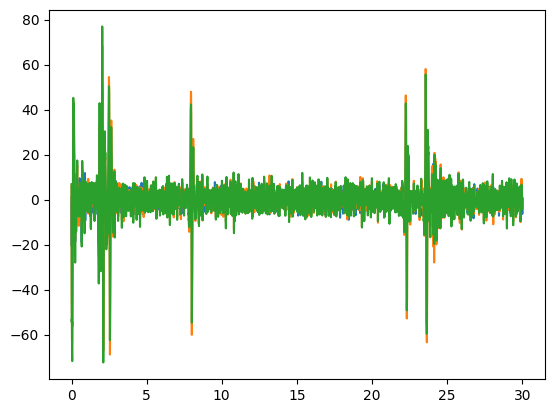

In [59]:
plt.plot(eeg_ts, blink_signal)
plt.plot(eeg_ts, clean_fp1)
plt.plot(eeg_ts, fp1)

In [50]:
marker_zero = pd.to_datetime(markers_df[markers_df['event_type'] == 'eeg_start']['timestamp'].iloc[0]) + pd.Timedelta(hours=4)
marker_zero_dt = pd.to_datetime(marker_zero)

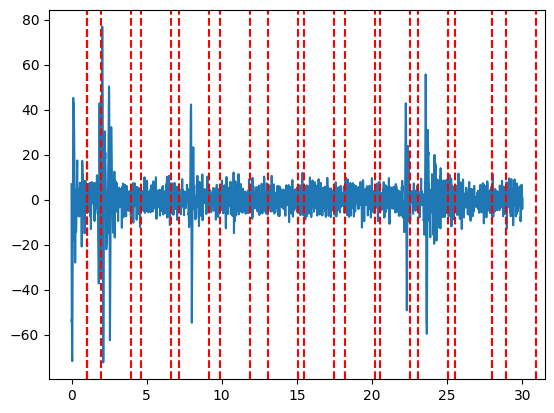

In [51]:
plt.plot(eeg_ts, eeg_ch1)
for i, row in markers_df.iterrows():
    if row['event_type'] == 'eeg_start':
        continue
    rel_s = (pd.to_datetime(row['timestamp'], utc=True) - pd.to_datetime(marker_zero, utc=True)).total_seconds()
    plt.axvline(x=rel_s, color='red', linestyle='--')
plt.show()